# Hyperparameter Optimization for Moving Average Trading Strategies

#### By Ryan Downing

#### April 27th, 2021

## Introduction

In this notebook I demonstrate methods for optimizing hyperparameters within systematic trading strategies. Hyperparameter tuning is the process of searching through a discrete or continuous search space to find the most efficient hyperparameters for a given problem. Hyperparameter optimization is a growing field of research because of its importance in training learning algorithms. However, in this showcase we will take the ideas and techniques from hyperparameter tuning in learning algorithms and apply it to systematic trading. Hyperparameters are unlike typical parameters that are dynamically selected by the algorithm itself such as the weights of neurons in a neural network, branches in a decision tree, or the daily holdings of an Alpha strategy. Instead hyperparameters affect how the algorithm itself behaves, and are normally preset by the researcher based on their expert knowledge of the specific problem. Unfortunately there is no direct way to select optimal hyperparameters, and researchers are forced to test many combinations of possible hyperparameters, only to settle for hyperparameters that are probably still sub-optimal. More recent research has proposed algorithmic methods for processing the search space of hyperparameters, with many employing bayesian inference or genetic algorithms. This notebook will explore some of these techniques while providing discussion on how to analyze the results and prevent overfitting while doing so.

### Prerequisites

This notebooks assumes you have the standard environment setup for SIF, however, it also uses a few packages that are not currently listed as dependencies for SIF. As such, before running this notebook, you will have to install additional packages with the `poetry` command below. Additionally, if running this notebook from scratch, you will need to have a few GB of storage space available for `ray.tune`'s trial caching, saving the backtesters, and saving search results.

```
poetry add seaborn plotly
```

### Notebook Setup

Below we import most of the external libraries we will be using for this experimentation

* `logging` - optionally used to show logs from backtesting
* `pickle` - save and load outputs from search results
* `numpy` - used in alpha strategies
* `pandas` - displaying results and creating visualizations
* `hyperopt/ray` - external libraries for hyperparameter tuning
* `matplotlib/seaborn/plotly` - used to create visualizations
* `sif...full_backtesters` - test alpha strategies, in sample and out of sample
* `sif...alpha_search` - module that wraps hyperparameter tuning functionality and other utilities
* `sif...AbstractAlpha/operators` - creation of alpha strategies

In [1]:
import logging
import pickle
import datetime
import numpy as np
import pandas as pd
from hyperopt import hp
from ray import tune
import matplotlib.pyplot as plt
import seaborn as sns
from sif.siftools.backtesters import full_backtesters as fb
from sif.sifinsights import alpha_search
from sif.siftools.abstractalpha import AbstractAlpha
from sif.siftools import operators as op
plt.rcParams['figure.figsize'] = (15, 9)

In [2]:
show_logs = False  # Set this to False if you do not want the logs to be shown
logger = None
if show_logs:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
else:
    import warnings
    warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

## In-sample Backtester

The backtesting environment we will test on will use the top 500 equities which is rebalanced every quarter (1/1, 4/1, 7/1, 10/1), and a maximum lookback of 252 trading days. Our full testing period will be from 1/1/2003 to 1/1/2020, but will be split into two periods, in-sample (1/1/2003 to 1/1/2015), and out-of-sample (1/1/2015 to 1/1/2020).

In [3]:
backtester = fb.FullMultipleBacktester(
    datetime.datetime(2003, 1, 1),
    datetime.datetime(2015, 1, 1),
    [(1, 1), (4, 1), (7, 1), (10, 1)],
    252,
    universe_size=500,
    factors=['close']
)

# Enter a path to save backtester for later usage
backtester.save_local('momo_opt_data.npy')

# Alternatively, if you have previously saved a backtester, uncomment the
# code below and insert the path to the '.npy' file it is saved as

# backtester = fb.FullMultipleBacktester.from_local('momo_opt_data.npy')

## Out-of-Sample Backtester

Out-of-sample backtester uses the same backtester environment settings as above, but we use the latter date range.

In [4]:
oos_backtester = fb.FullMultipleBacktester(
    datetime.datetime(2015, 1, 1),
    datetime.datetime(2020, 1, 1),
    [(1, 1), (4, 1), (7, 1), (10, 1)],
    252,
    universe_size=500,
    factors=['close']
)

# Enter a path to save backtester for later usage
oos_backtester.save_local('momo_oos_opt_data.npy')

# Alternatively, if you have previously saved a backtester, uncomment the
# code below and insert the path to the '.npy' file it is saved as

# oos_backtester = fb.FullMultipleBacktester.from_local('momo_oos_opt_data.npy')

## Parametrized Alphas

The strategies we will be tuning are moving average strategies created by Shahnawaz Khalid, more information about them specifically can be found in [Alpha Strategies: Algorithmic Technical Analysis](https://www.smithinvestmentfund.com/blog/algorithmic-technical-analysis). We will test a total of three different strategies, single moving average, double moving average, and triple moving average. The important thing to note is the difference in the number of hyperparameters for each strategy: 1, 2, and 3 respectively. Each correspond to the window length to compute the moving average(s) for each strategy. 

In [5]:
class SingleMoving(AbstractAlpha):
    def __init__(self, t1):
        self.name = 'single_moving_avg'
        self.lookback = t1
        self.factor_list = ['close']
        self.universe_size = 500

    def generate_day(self, day, data):
        '''
        Long only strategy. We skip the most recent month when looking at past returns.
        '''
        skip = 21

        # Computing the mean, standard deviation and risk adjusted returns
        returns = op.ret(data['close'][:-skip])
        mean_ret = op.mean(returns)

        # Sorting stocks according to returns
        ind = mean_ret.argsort()
        percentile = 0.1  # Picking the percentile of stocks to include in the portfolio
        limit = int(self.universe_size * percentile)
        top_ind = ind[-limit:]  # Indices for stocks with highest return

        holdings = np.zeros_like(data['close'][day])
        holdings[top_ind] = 1. / len(top_ind)  # Uniform weights for each stock

        return holdings
    
    
class DoubleMoving(AbstractAlpha):
    def __init__(self, t1, t2):
        self.name = 'double_moving_avg'
        self.lookback = t1
        self.factor_list = ['close']
        self.universe_size = 500
        self.t2 = t2

    def generate_day(self, day, data):
        t2 = self.t2  # time length for the shorter MA
        sma = op.mean(data['close'], axis=0)  # Longer moving average
        sma_t2 = op.mean(data['close'][day - t2 + 1:], axis=0)  # Shorter moving average

        long = (sma_t2 > sma).sum()
        holdings = (sma_t2 > sma).astype(int)

        return holdings / long


class TripleMoving(AbstractAlpha):
    def __init__(self, t1, t2, t3):
        self.name = 'triple_moving_avg'
        self.lookback = t1 #200
        self.factor_list = ['close']
        self.universe_size = 500
        self.holding = np.zeros(500)  # stores the previously held portfolio weights
        self.t2 = t2
        self.t3 = t3

    def generate_day(self, day, data):
        """
        t3 < t2 < lookback
        """
        sma = op.mean(data['close'], axis=0)  # Longest moving average
        sma_t2 = op.mean(data['close'][day - self.t2 + 1:], axis=0)  # Middle moving average
        sma_t3 = op.mean(data['close'][day - self.t3 + 1:], axis=0)  # Shortest moving average

        liquidate = (sma_t3 < sma_t2)  # indices to liquidate position
        self.holding[liquidate] = 0

        long1 = (sma_t2 > sma)
        long2 = (sma_t3 > sma_t2)
        long = np.logical_and(long1, long2)  # indices to go long
        self.holding[long] = 1

        return self.holding / sum(self.holding)

# We actually will just import these classes from a separate file so we can safely use multiprocessing
from trading_strategies import SingleMoving, DoubleMoving, TripleMoving

## Single Moving Average Optimization

To start looking into hyperparameter optimization will we begin with the `SingleMoving` alpha strategy which implements the single moving average trading signal. This is the simplest of the three strategies we will be looking into as it requires only one hyperparameter, the window length for the moving average. Since our backtest environment has a maximum lookback of 252 trading days, the largest hyperparameter we will test is 252. We also do not want super small window sizes, so lets set the smallest to 5. Therefore our possible hyperparameter space is given by `np.arange(5, 253)`, with a total of 248 different options. Since this is a still a reasonable number of combinations, we can simply perform a grid search to test all the possibilities.

In [6]:
grid = {'t1': np.arange(5, 253)}
# single_result = alpha_search.grid_search(SingleMoving, backtester, 'return', grid, processes=0, store_results=False)

In [7]:
# with open('single_search_result.pkl', 'wb') as f:
#     pickle.dump(single_result, f)

with open('single_search_result.pkl', 'rb') as f:
    single_result = pickle.load(f)
print(single_result)

This search result contains 248 trials across 1 parameters
The best alpha achieved a score of 2.1056491418023677 on trial 97 with parameters: {'t1': 102}
The following parameter importances are calculated using a relative weights analysis:
{'param_t1': 1.0}


### Results & Analysis

As we can see from the results above and the graph below, hyperparameter optimization on a simple strategy such as this may not present much benefit. The returns gained from adjusting the window size vary erratically and do not present any clear pattern. The best we can infer from this data is that the optimal window size is between 70 and 110, where the returns are somewhat stable and consistently earn an above average score.

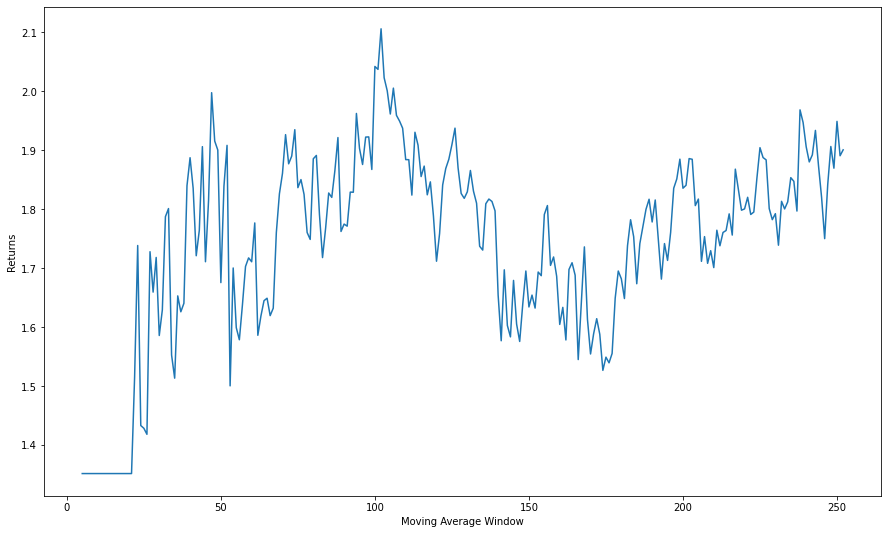

In [8]:
plt.plot(single_result.results['param_t1'], single_result.results['score'])
plt.xlabel('Moving Average Window')
plt.ylabel('Returns')
plt.show()

## Double Moving Average Optimization

For the `DoubleMoving` alpha strategy (double moving average crossover), we have two hyperparameters to tune, 1 integer for each moving average window size. Since the strategy requires the first window size to be larger than the second, there is an inherent dependency between the parameters' search spaces. We implement this with `lambda spec: tune.randint(5, spec.config.t1)` which ensures the latter window size, `t2`, is at most `t1 - 1`. As such, if `t1 = 6`, `t2` must be `5`, and if `t1 = 7`, then `t2` may be `5` or `6`. This gives us $\sum_{t_1=6}^{252} (t_1 - 5) = 30628$ possible combinations for our hyperparameters. Due to the dependency in the variables, only the random parameter selection is supported by `ray.tune`. In this case we I have run 4096 trials to gain a strong representation of the search space. 

### Returns Optimization

The first optimization will be purely based on returns. The score will simply be calculated as the total returns over the entire backtest period. After the 4096 trials are completed for the returns optimization, we find that the best scoring trial was with parameters `t1 = 78` and `t2 = 71`, representing window sizes of 78 and 71 trading days respectively. The backtest completed using those hyperparameters resulted in a total return of `1.383` or `138.3%` over the 12 year period. Furthermore, by computing the relative weights analysis ([Toniandel and LeBerton (2015)](https://pubmed.ncbi.nlm.nih.gov/18361636/)) we can deduce that the `t1` hyperparameter plays a far more important role in determining the performance of the alpha strategy, with `80%` weight assigned to that hyperparameter, and only `20%` to the `t2` hyperparameter.

In [9]:
space = {'t1': tune.randint(6, 253), 't2': tune.sample_from(lambda spec: tune.randint(5, spec.config.t1))}
# result = alpha_search.tune_search(DoubleMoving, backtester, 'return', space, 4096, algo='random', seed=42, verbose=1, resources={'cpu': 1}, store_results=False)

In [10]:
# with open('double_search_result.pkl', 'wb') as f:
#     pickle.dump(double_result, f)

with open('double_search_result.pkl', 'rb') as f:
    double_result = pickle.load(f)
print(double_result)

This search result contains 4096 trials across 2 parameters
The best alpha achieved a score of 1.383177761567128 on trial 3657 with parameters: {'t1': 78, 't2': 71}
The following parameter importances are calculated using a relative weights analysis:
{'param_t1': 0.8012190590940054, 'param_t2': 0.19878094090599438}


#### Results & Analysis

The first set of graphs below show the distribution of the hyperparameters with respect to the score achieved by that trial. A color gradient is added to show the varying difference between the larger and smaller window lengths, allowing us to see if any relationship exists there. Starting with the bottom graph is this set, we can see if the difference in the window sizes has any significant effect on the returns of the strategy, this graph gives us a *pseudo*-legend for the color gradient in the other graphs. The `MA Difference` graph shows us that in order to achieve *average* returns of around 1 to 1.2, the difference in window sizes does not have much effect, with many trials achieving such returns at every MA Difference level. However, towards the left end of the graph, those trials with smaller MA differences (especially those `<50`), have the possibility to achieve returns `>1.2`, though also vary more widely with some scoring as low as `0.4` to `0.6`. The top two graphs present a similar story in which we see that each window size individually doesn not have a huge effect on the outcome, but rather the combination of them together is what really influences the strategy's performance. Similar to the single hyperparameter optimization, in the top graph we see that the optimal window size of the large moving average consistently falls between 70 and 110. Lastly, the distribution in the second window size, `Small MA`, depicts a similar story. The returns are relatively consistent across window sizes, but around 50 to 100 seems to be able to achieve peak performance. Further, we see that the majority of the data points which are above average are those with smaller window size differences. This is expected because the closer the moving averages are together, the trends the signals pick up are more recent and are able to exploit more of the momentum arbitrage.

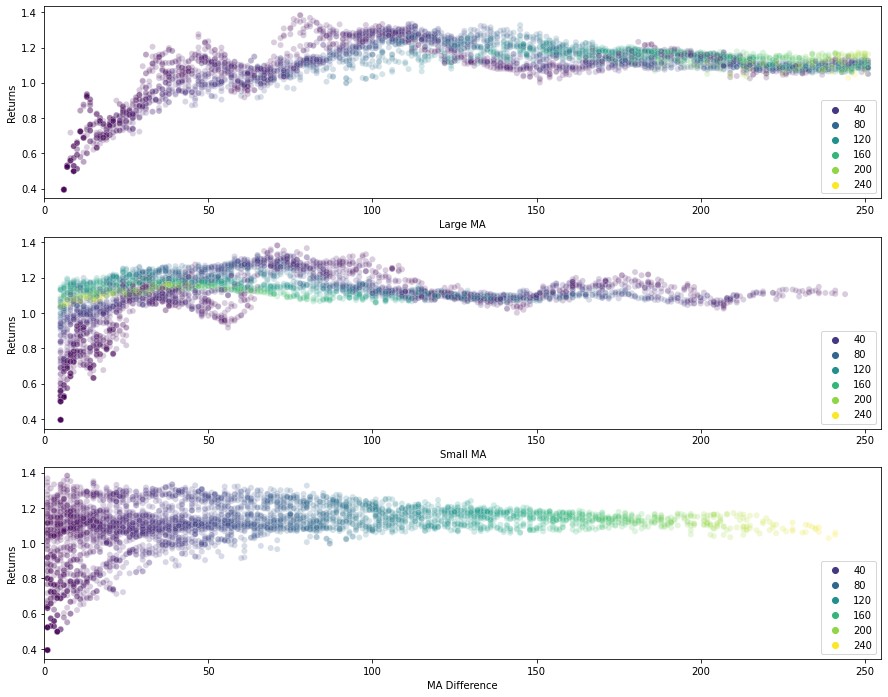

In [11]:
df = double_result.results
df.eval('diff = param_t1 - param_t2', inplace=True)
_, axes = fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 12))
sns.scatterplot(x=df['param_t1'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax1, alpha=.2)
sns.scatterplot(x=df['param_t2'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis,ax=ax2, alpha=.2)
sns.scatterplot(x=df['diff'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax3, alpha=.2)

ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax2.set_xlim(0, 255)
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_ylabel('Returns')
    ax.set_xlim(0, 255)
    ax.legend(loc='lower right')
fig.show()

In [12]:
n = 100
top_n = df[['param_t1', 'param_t2', 'diff', 'score']].sort_values('score', ascending=False).iloc[:n, :]
top_n

param_t1  param_t2  diff     score
trial_id                                       
8dc8e_03657        78        71     7  1.383178
8dc8e_03793        78        71     7  1.383178
8dc8e_00325        81        80     1  1.367881
8dc8e_00950        76        69     7  1.361372
8dc8e_02450        79        73     6  1.354719
...               ...       ...   ...       ...
8dc8e_02414       101        86    15  1.294612
8dc8e_00742       104        71    33  1.294503
8dc8e_00627       128        73    55  1.294395
8dc8e_01893        83        71    12  1.294274
8dc8e_00916       109        67    42  1.294173

[100 rows x 4 columns]

#### Results & Analysis

In the above code block we select only the results from the top 100 trials in order to look more closely at this distribution. If there is a significant relationship, we should see the hyperparameters for the top 100 trials fall in a cluster rather than being randomly distributed amongst the search space. As such, from the two sets of graphs below we can see that the results do seem statistically significant as the spread of the hyperparameters for the top 100 results are fairly concentrated to just a small clump of the distribution and a low number of outliers. Further, as we can tell from the condensed gradient (legend shrunk), the smaller differences in window sizes are majorly preferred as suspected because of their quicker reactivity and turnover.

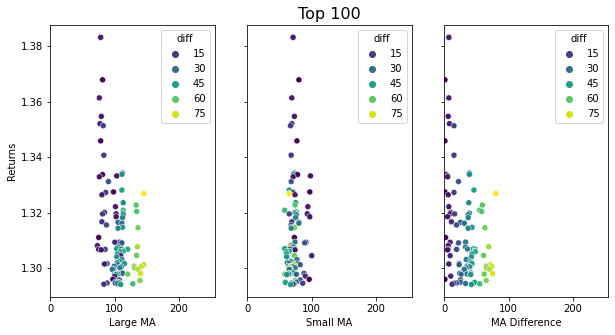

In [13]:
_, axes = fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
sns.scatterplot(x=top_n['param_t1'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax1)
sns.scatterplot(x=top_n['param_t2'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax2)
sns.scatterplot(x=top_n['diff'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax3)

ax2.set_title('Top 100', fontsize=16)
ax1.set_ylabel('Returns')
ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_xlim(0, 255)
fig.show()

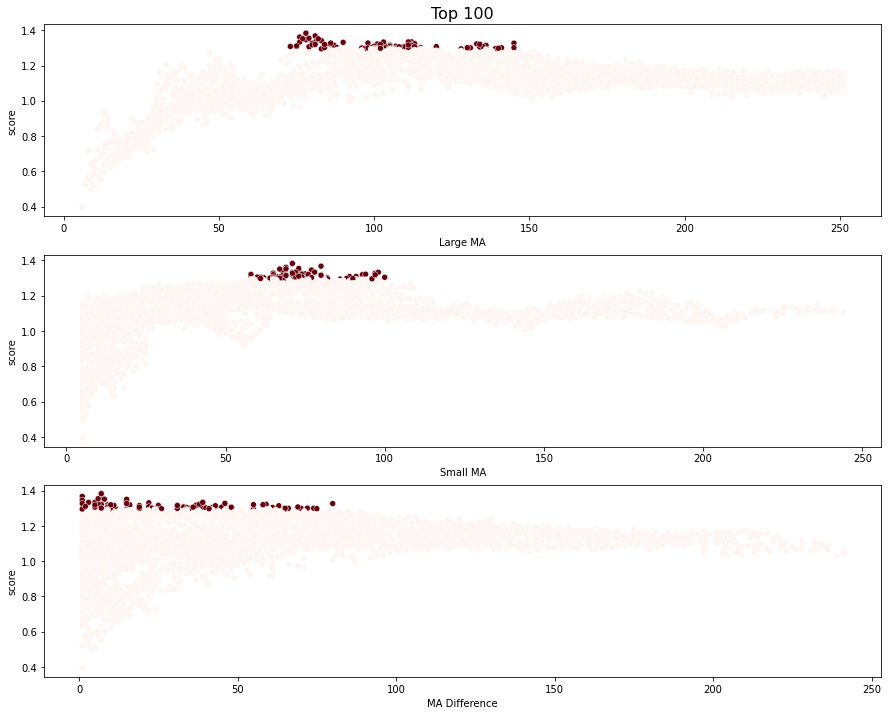

In [14]:
_, axes = fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 12))
df['is_top_n'] = df.index.isin(top_n.index)
sns.scatterplot(x=df['param_t1'], y=df['score'], c=df['is_top_n'], ax=ax1, cmap=plt.cm.Reds)
sns.scatterplot(x=df['param_t2'], y=df['score'], c=df['is_top_n'], ax=ax2, cmap=plt.cm.Reds)
sns.scatterplot(x=df['diff'], y=df['score'], c=df['is_top_n'], ax=ax3, cmap=plt.cm.Reds)

ax1.set_title('Top 100', fontsize=16)
ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax3.set_xlabel('MA Difference')
fig.show()

#### Results & Analysis

The next graphs present the distribution of both hyperparameters with the score (total returns) used as a third axis. In the first graph the third axis, `score`, is the hue of the scatter plot. This plot shows us the dependency in the hyperparameters as `y < x` is enforced because of the window sizes. It also begins to give us an idea of slope of the strategy performance with respect to both parameters. It is mostly blue and green but begins to converge to a yellow peak near the `(75, 50)` point. Additionally, it the score dives to purple near the origin where the alpha strategy's performance suffers. This is more clearly seen in the following graph where we add the `z-axis` for the score, which allows us to see the degrading performance within the very small window sizes, and then the areas where the strategy excels higlighted in the yellow peaks.

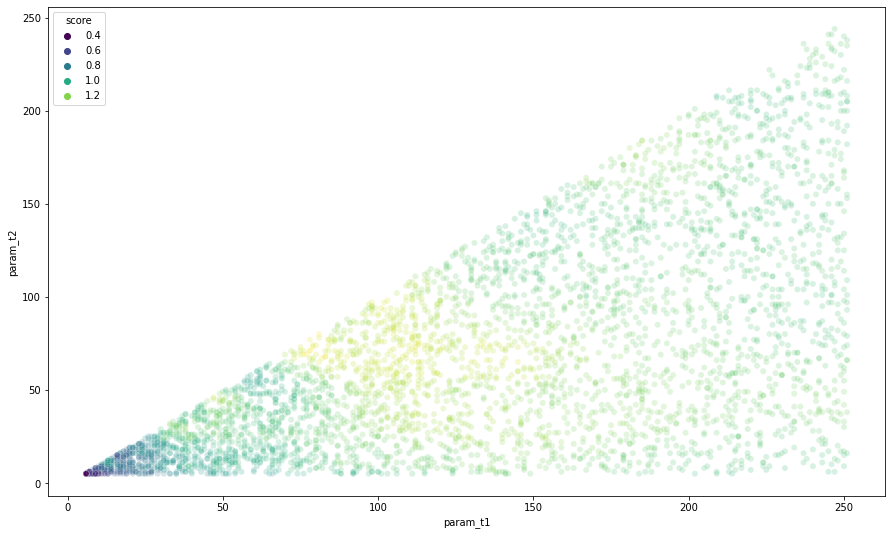

In [15]:
sns.scatterplot(x=df['param_t1'], y=df['param_t2'], hue=df['score'], palette=plt.cm.viridis, alpha=.2)
fig.show()

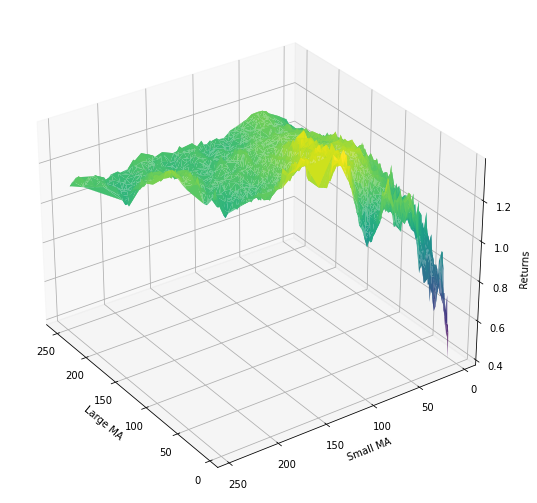

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['param_t1'], df['param_t2'], df['score'], cmap=plt.cm.viridis)
ax.set_xlabel('Large MA')
ax.set_ylabel('Small MA')
ax.set_zlabel('Returns')
ax.view_init(30, 145)
fig.show()

### Sharpe Ratio Optimization

In the next section I redo the simulation on the `DoubleMoving` alpha strategy but now calculate use sharpe ratio as the performance metric to optimize. This could be done by using the last trials results, and computing the sharpe ratio from those, but that would require saving 4096 backtest results which is difficult to load into memory. In a later version I hope to add better support for this, but for now running 4096 new trials is easy enough by using the same function but changing the metric tracked. Interestingly, the weight analysis from this optimization had very similar results as the returns optimization, with `80%` of the sharpe performance being attributed to the large window, `t1`. Additionally, the optimized smaller window, `t2`, was `71`, which is just one off the `72` found in the returns optimization. Though the best large moving average was with `108` trading days, differing significantly from the previously found `78`. This best trial achieved a sharpe ratio of `0.0466`, this is not annualized so it is off by a factor of $\sqrt{252}$.

In [17]:
space = {'t1': tune.randint(6, 253), 't2': tune.sample_from(lambda spec: tune.randint(5, spec.config.t1))}
# sharpe_result = alpha_search.tune_search(DoubleMoving, backtester, 'sharpe', space, 4096, algo='random', seed=42, verbose=1, resources={'cpu': 1}, store_results=False)

In [18]:
# with open('double_sharpe_search_result.pkl', 'wb') as f:
#     pickle.dump(sharpe_result, f)

with open('double_sharpe_search_result.pkl', 'rb') as f:
    sharpe_result = pickle.load(f)
print(sharpe_result)

This search result contains 4096 trials across 2 parameters
The best alpha achieved a score of 0.046622257471632254 on trial 3158 with parameters: {'t1': 108, 't2': 72}
The following parameter importances are calculated using a relative weights analysis:
{'param_t1': 0.7976820422382226, 'param_t2': 0.20231795776177727}


#### Results & Analysis

Similar to the last analysis, below we have the distributions for the hyperparameters against the sharpe ratios achieved for those trials. These graphs look quite similar to the last, but also have some unique differences. In these graphs we are able to more clearly see that those strategies with high large moving averages benefit from also having a bigger difference in the window sizes as shown by the brighter gradient towards the right end of the first graph. This is further highlighted by the influx of large MA differences on the upper left of the `Small MA` distribution, showing that the very small MA paired with very large MA is often successful. The scenario with the bottom graph, `MA difference`, mostly remains the same, showing that almost any MA difference can achieve an average sharpe ratio, but the smaller ones seem to consistently do marginally better, peaking around 50.

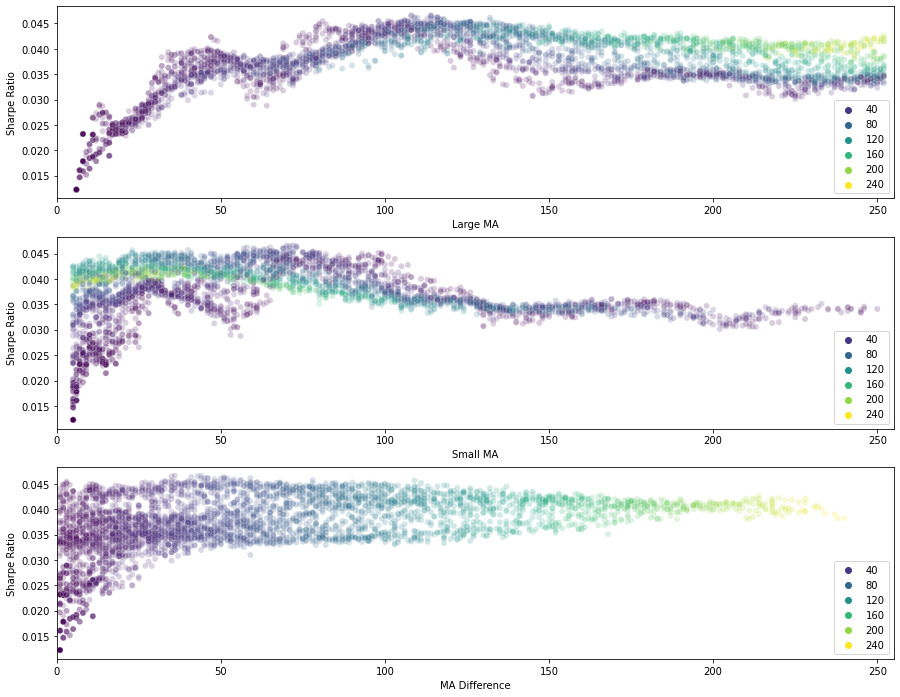

In [19]:
df = sharpe_result.results
df.eval('diff = param_t1 - param_t2', inplace=True)

_, axes = fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 12))
sns.scatterplot(x=df['param_t1'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax1, alpha=.2)
sns.scatterplot(x=df['param_t2'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax2, alpha=.2)
sns.scatterplot(x=df['diff'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax3, alpha=.2)

ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax2.set_xlim(0, 255)
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xlim(0, 255)
    ax.legend(loc='lower right')
fig.show()

In [20]:
n = 100
top_n = df[['param_t1', 'param_t2', 'diff', 'score']].sort_values('score', ascending=False).iloc[:n, :]
top_n

param_t1  param_t2  diff     score
trial_id                                       
88038_03158       108        72    36  0.046622
88038_02195       114        70    44  0.046618
88038_00702       114        71    43  0.046539
88038_00685       108        73    35  0.046490
88038_02586       114        73    41  0.046353
...               ...       ...   ...       ...
88038_03753        80        70    10  0.044939
88038_00404       105        60    45  0.044936
88038_02771       123        26    97  0.044928
88038_00207       124        36    88  0.044922
88038_03978       124        36    88  0.044922

[100 rows x 4 columns]

#### Results & Analysis

Again we will take a look at the hyperparameters from the top 100 results, this time for the sharpe ratio optimization. This is very similar to what we saw previously, but it should be noted that the `Large MA` seems to be even more concentrated, and tending towards `100-130` instead of `70-110`. Conversely, the `Small MA` became less concentrated, including much smaller windows in the top 100. The `MA difference` shrunk, but remained slightly bigger than that in the returns optimization, demonstrating the sharpe ratio's tendency to prefer strategies that are more slow moving and thus have lower volatility.

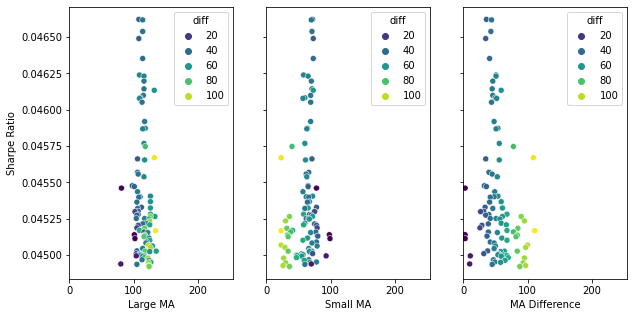

In [21]:
_, axes = fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10, 5))
sns.scatterplot(x=top_n['param_t1'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax1)
sns.scatterplot(x=top_n['param_t2'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax2)
sns.scatterplot(x=top_n['diff'], y=top_n['score'], hue=top_n['diff'], palette=plt.cm.viridis, ax=ax3)
ax1.set_ylabel('Sharpe Ratio')
ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_xlim(0, 255)
fig.show()

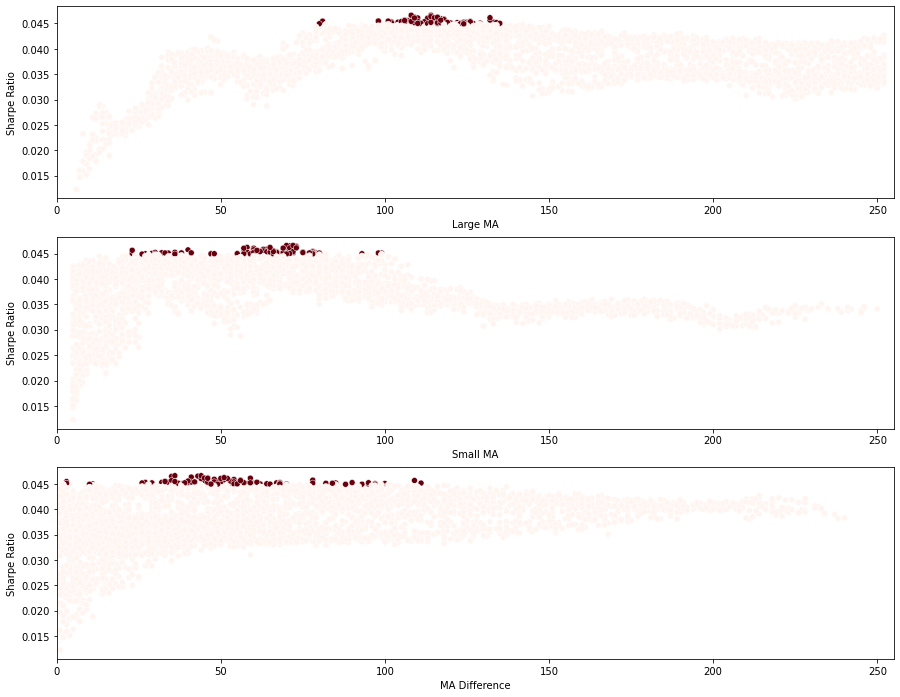

In [22]:
_, axes = fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 12))
df['is_top_n'] = df.index.isin(top_n.index)
sns.scatterplot(x=df['param_t1'], y=df['score'], c=df['is_top_n'], ax=ax1, cmap=plt.cm.Reds)
sns.scatterplot(x=df['param_t2'], y=df['score'], c=df['is_top_n'], ax=ax2, cmap=plt.cm.Reds)
sns.scatterplot(x=df['diff'], y=df['score'], c=df['is_top_n'], ax=ax3, cmap=plt.cm.Reds)
ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xlim(0, 255)
fig.show()

#### Results & Analysis

The 3d contour plot of the hyperparameters distributed against the sharpe ratio is by far the most interesting visualization from this adjusted simulation. From this we can exactly see the difference in the performance gradient between the optimization on returns and now on sharpe ratio. The same effect towards the origin is repeated here with the combination of two small moving averages resulting in very poor performance. However, in the higher area we see that this gradient is smoother than that of the returns optimization and created a more defined peak, clearly converging from both sides towards the maximum sharpe ratio. This also shows that the peak area is more of a cluster which should direct our implementation of such an optimization in a future strategy. Instead of simply selecting the best hyperparameters, this gives evidence that a *bagged* strategy, or an average of the top N hyperparameters may provide better, or at least more consistent returns. This will be explored more below when we look at the out-of-sample performance.

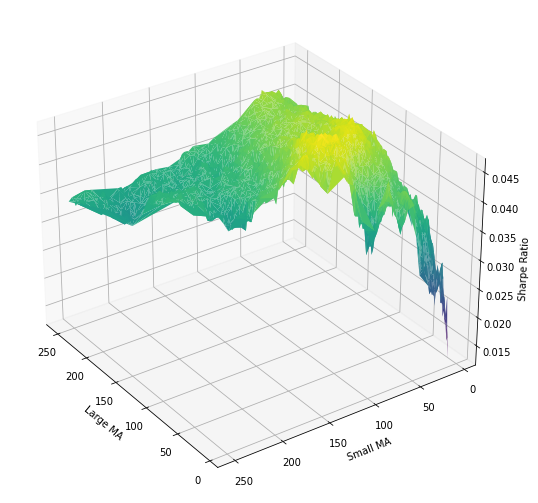

In [23]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['param_t1'], df['param_t2'], df['score'], cmap=plt.cm.viridis)
ax.set_xlabel('Large MA')
ax.set_ylabel('Small MA')
ax.set_zlabel('Sharpe Ratio')
ax.view_init(30, 145)
fig.show()

### Custom Evaluation Optimization

This next section showcases a very powerful part of this hyperparameter pipeline. It gives the researcher the ability to provide a custom evaluation metric function. Using this, we are able to create a custom metric that is based on the returns and holdings of the backtested strategy. This is a perfect time to revisit one of our earlier issues found with the returns optimization, which was heavily favoring double moving averages where the window sizes were close together. I suspected this was from the signal's ability to quickly pickup recent trends and allocate the strategy's portfolio accordingly. This would result in high turnover and in real-world trading would have large transaction costs, eating away at the supposed profits we were gaining. Therefore, the custom evaluation function I have devised combines the last two optimizations as well as adding a punishing factor for the daily turnover of the strategy. The final metric is an average of the yearly return minus 5% for every 100% daily turnover, and the annualized sharpe ratio. The sharpe ratio heavily influences the final score due to its greater mean, but the yearly return and turnover play crucial roles in the overall optimization which we will explore below.

For the third and final time we run 4096 trials on the `DoubleMoving` strategy, this time using the custom evaluation metric. The best hyperparameters from this optimization are much different than before, with `t1=238` and `t2=52`. The best score achieved was `0.277`, but it is hard to intrepret in the context of the custom metric and it is more useful as a relative comparison to the other hyperparameters. The relative weights analysis still remains consistent, with the approximate `80%` weight being attributed to the larger window size, though we should consider this could partly be due to the ability for the larger window to vary more widely and also directly influences the distribution of the smaller window.

In [24]:
from sif.siftools import metrics

def custom_eval(returns, holdings):
    holdings = holdings.values
    turnover = np.nanmean(
        np.nansum(np.abs(
            metrics.compute_turnover(holdings)
        ), axis=1).astype(np.float64)
    ) * 252
    sharpe = metrics.sharpe_ratio(returns, annualized=True)
    yearly_ret = np.nanmean(returns) * 252
    return .5 * (yearly_ret - 0.05 * turnover) + .5 * sharpe

multiple_custom_eval = alpha_search.apply_metric_func(custom_eval, ('returns', 'holdings'))

In [25]:
space = {'t1': tune.randint(6, 253), 't2': tune.sample_from(lambda spec: tune.randint(5, spec.config.t1))}
# custom_result = alpha_search.tune_search(
#     DoubleMoving, backtester, multiple_custom_eval, space, 4096,
#     algo='random', seed=42, verbose=1, resources={'cpu': 1}, store_results=False
# )

In [26]:
# with open('double_custom_eval_search_result.pkl', 'wb') as f:
#     pickle.dump(custom_result, f)

with open('double_custom_eval_search_result.pkl', 'rb') as f:
    custom_result = pickle.load(f)
print(custom_result)

This search result contains 4096 trials across 2 parameters
The best alpha achieved a score of 0.27748171759213375 on trial 2077 with parameters: {'t1': 238, 't2': 52}
The following parameter importances are calculated using a relative weights analysis:
{'param_t1': 0.8188927367332596, 'param_t2': 0.18110726326674043}


#### Results & Analysis

Next we can look at the contour of the hyperparameter distribution where the z-axis represents the custom metric score. For the purposes of this visualization I have removed all of the points which resulted in a negative score in order to focus on the optimal area of the distribution. This gradient is very interesting as it is uniquely different from the previous two contours. The hyperparameters form much more of a ridge shape, instead of the convex valleys seen in the returns and sharpe optimization. We see a similar gradient distribution for the small moving average, with the performance gradually increasing until peaking in the optimal 50-80 range. Howevever, we can also see the effects of the custom metric in this gradient. The optimal large moving average is much more concentrated right above 200, where the large window was optimally found around 100 in the previous optimizations.

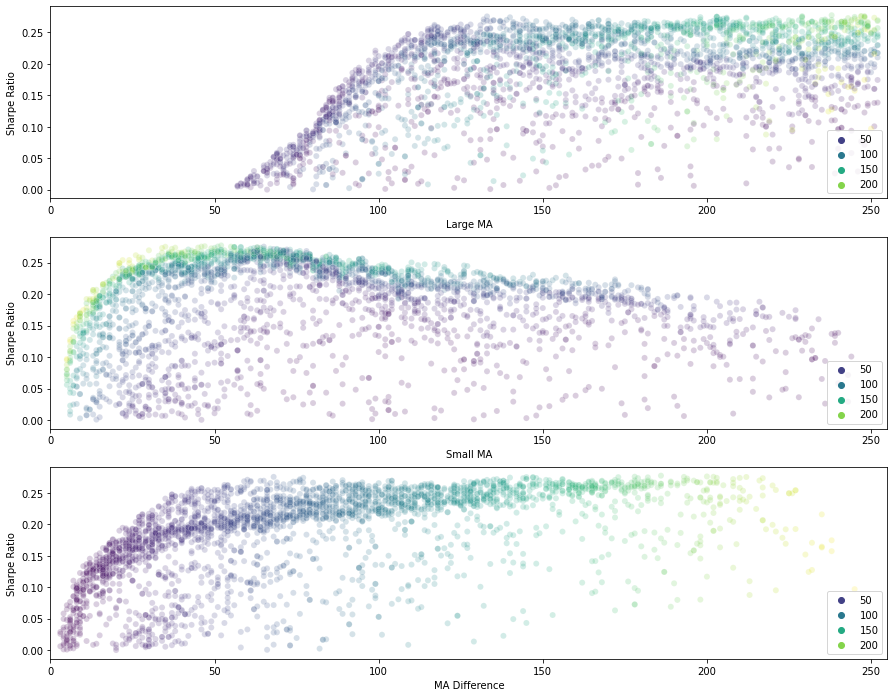

In [27]:
df = custom_result.results.query('score > 0')
df.eval('diff = param_t1 - param_t2', inplace=True)

_, axes = fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, figsize=(15, 12))
sns.scatterplot(x=df['param_t1'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax1, alpha=.2)
sns.scatterplot(x=df['param_t2'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax2, alpha=.2)
sns.scatterplot(x=df['diff'], y=df['score'], hue=df['diff'], palette=plt.cm.viridis, ax=ax3, alpha=.2)

ax1.set_xlabel('Large MA')
ax2.set_xlabel('Small MA')
ax2.set_xlim(0, 255)
ax3.set_xlabel('MA Difference')
for ax in axes:
    ax.set_ylabel('Sharpe Ratio')
    ax.set_xlim(0, 255)
    ax.legend(loc='lower right')
fig.show()

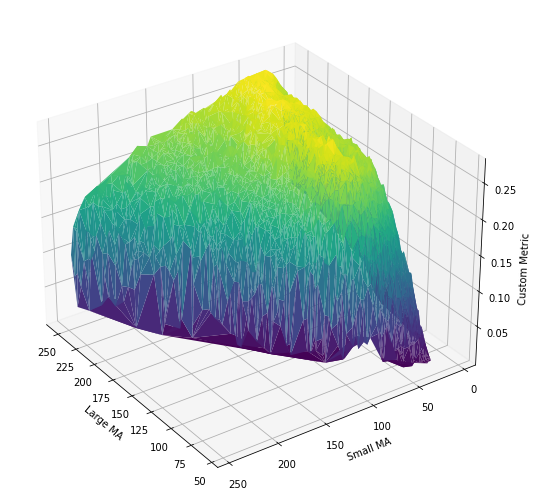

In [28]:
df = custom_result.results
df.eval('diff = param_t1 - param_t2', inplace=True)
df = df.query('score > 0')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['param_t1'], df['param_t2'], df['score'], cmap=plt.cm.viridis)
ax.set_xlabel('Large MA')
ax.set_ylabel('Small MA')
ax.set_zlabel('Custom Metric')
ax.view_init(30, 145)
fig.show()

### Optimization Comparison

Now that we have completed simulations for tuning the hyperparameters of the `DoubleMoving` alpha strategy under three different optimization metrics, lets compare the results across the three runs. First we look at the full gradient of each optimization to gain an understanding of the overall distributions. This shows why zooming in on the custom metric gradient was necessary in the previous graph, without doing so it is hard to see the relevant distribution due to the distortion caused by the collapsing score near the origin. This nose-dive near the origin was most likely due to a coupling effect, where those strategies did not manage above average returns or sharpe ratio (as seen in the returns and sharpe ratio gradient), and also have very high turnover because of their low window sizes, thus resulting in a very low score given by our custom metric. The left two graphs in this set better show the differences between the returns and sharpe ratio hyperparameter distribution. They are strikingly similar but do have noticeable differences in the flatter areas as the global maximum for each converge to different areas of the distribution.

In the bottom set of graphs I display the same gradients, but now filter the trials for each optimization by dropping the bottom 25% trials based on their score. This allows us to focus on the portion of the distribution closer to the optimum. Once again the returns and sharpe ratio optimizations present themselves similarly, much more jagged and volatile to small hyperparameter adjustments than that of the custom evaluation metric. It is very interesting how much the custom optimization contour differs from the other two. Given that it is simply a transformation of the backtested results, I expected it to not differ all that much from the previous two optimizations. Instead though, we find that the custom optimization presents a *range* of possible hyperparameters that achieve a very similar optimal score, rather than the small specific clusters formed in the returns and sharpe ratio contours. This may be showing the tradeoff between smaller windows -> greater return and greater turnover -> equivalent post-transaction-cost returns, however a closer investigation into the results of these trials are needed to confirm such suspicion.

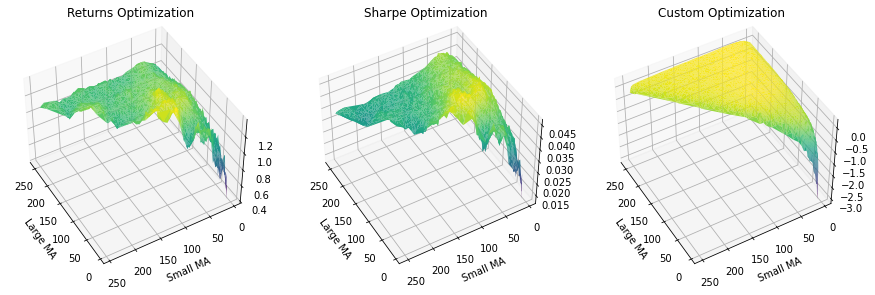

In [29]:
returns_df = double_result.results
sharpe_df = sharpe_result.results
custom_eval_df = custom_result.results

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.plot_trisurf(returns_df['param_t1'], returns_df['param_t2'], returns_df['score'], cmap=plt.cm.viridis)
ax2.plot_trisurf(sharpe_df['param_t1'], sharpe_df['param_t2'], sharpe_df['score'], cmap=plt.cm.viridis)
ax3.plot_trisurf(custom_eval_df['param_t1'], custom_eval_df['param_t2'], custom_eval_df['score'], cmap=plt.cm.viridis)
for ax in (ax1, ax2, ax3):
    ax.view_init(45, 150)
    ax.set_xlabel('Large MA')
    ax.set_ylabel('Small MA')
ax1.set_title('Returns Optimization')
ax2.set_title('Sharpe Optimization')
ax3.set_title('Custom Optimization')
fig.show()

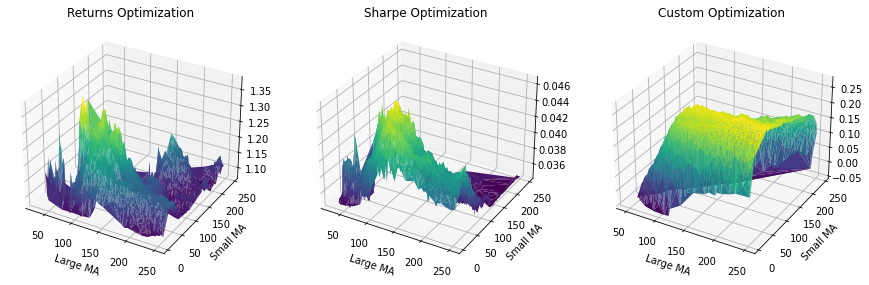

In [30]:
q = .25
returns_df = returns_df[returns_df['score'] >= returns_df['score'].quantile(q)]
sharpe_df = sharpe_df[sharpe_df['score'] >= sharpe_df['score'].quantile(q)]
custom_eval_df = custom_eval_df[custom_eval_df['score'] >= custom_eval_df['score'].quantile(q)]

fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax1.plot_trisurf(returns_df['param_t1'], returns_df['param_t2'], returns_df['score'], cmap=plt.cm.viridis)
ax2.plot_trisurf(sharpe_df['param_t1'], sharpe_df['param_t2'], sharpe_df['score'], cmap=plt.cm.viridis)
ax3.plot_trisurf(custom_eval_df['param_t1'], custom_eval_df['param_t2'], custom_eval_df['score'], cmap=plt.cm.viridis)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Large MA')
    ax.set_ylabel('Small MA')
ax1.set_title('Returns Optimization')
ax2.set_title('Sharpe Optimization')
ax3.set_title('Custom Optimization')
fig.show()

### Out-of-Sample Analysis

In this section we move on entriely from hyperparameter optimization and solely look at the results while re-evaluating them using an out-of-sample period. This assessment is crucial in understanding if our optimization was truely beneficial to the predictive power of the strategy, or if it simply overfit the in-sample data which could be a detriment to the strategy as a whole. To test this fact I grab the top 5 hyperparameters from each optimization and run the alpha strategy with those hyperparameters using our out-of-sample backtester which runs the stategy over a 5 year period (2015-2020). The top 5 hyperparameters from each optimization are shown below and do not have any overlap. Here it is clear that despite finding similar optimal ranges for `param_t2`, the optimization on the `param_t1` differed aggressively based on the optimization used. The custom hyperparameters do have one outlier with `t1=133` in the fifth trial as opposed to `228 < t1 < 249` in the top 4. The remaining hyperparameters do appear consistent, forming clusters.

In [31]:
n = 5
double_results = [double_result.top_n_results(n), sharpe_result.top_n_results(n), custom_result.top_n_results(n)]
double_returns, double_holdings = oos_backtester.backtest(
    double_result.top_n_alphas(n) + sharpe_result.top_n_alphas(n) + custom_result.top_n_alphas(n) + [DoubleMoving(200, 15)]
)

Done!: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


In [32]:
from IPython.core import display as ICD
for name, res in zip(['returns optimization', 'sharpe optimization', 'custom optimization'], double_results):
    print(name)
    ICD.display(res[['param_t1', 'param_t2', 'score']].reset_index(drop=True))

returns optimization


param_t1  param_t2     score
0        78        71  1.383178
1        78        71  1.383178
2        81        80  1.367881
3        76        69  1.361372
4        79        73  1.354719

sharpe optimization


param_t1  param_t2     score
0       108        72  0.046622
1       114        70  0.046618
2       114        71  0.046539
3       108        73  0.046490
4       114        73  0.046353

custom optimization


param_t1  param_t2     score
0       238        52  0.277482
1       247        47  0.276215
2       229        51  0.275797
3       248        46  0.275652
4       133        65  0.275562

#### Results & Analysis

In the first graph below I plot the cumulative returns of all the top 5 hyperparameters: returns in blue, sharpe ratio is yellow, custom in green, and a baseline (from Shahnawaz's original strategy). We can immediately tell these are all very similar signals, which makes sense because we are only slightly adjusting the strategy through its hyperparameters. In the beginning and end of the time period the groups of returns' alphas performed the best, but from 2016 2019 it appears the baseline performed the best, tracked closely by the group of custom metric alphas. The alphas from the sharpe and returns' optimizations switch frequently at the bottom of the performance throughout this chunk as well. Only the sharpe alphas finish below the baseline, but they are all very close and it is unclear if any appreciable differences were seen from the optimization compared to the baseline.

This is more clearly seen in the second graph which groups the top 5 alphas from each strategy, forming a single equal-weighted alpha for each optimization (also called bagging; bagged alpha). The same relationships are seen between each optimization, though we can more accurately observe the performance we would see if we implemented this as its own strategy - using a group of top hyperparameters rather than relying on a single choice. By looking at the bagged alphas, the performance gained from the optimization does not seem to be very much for this strategy so either the baseline hyperparameters were already set well, or the hyperparameters for this strategy do not have much influence on the overall strategy's performance.

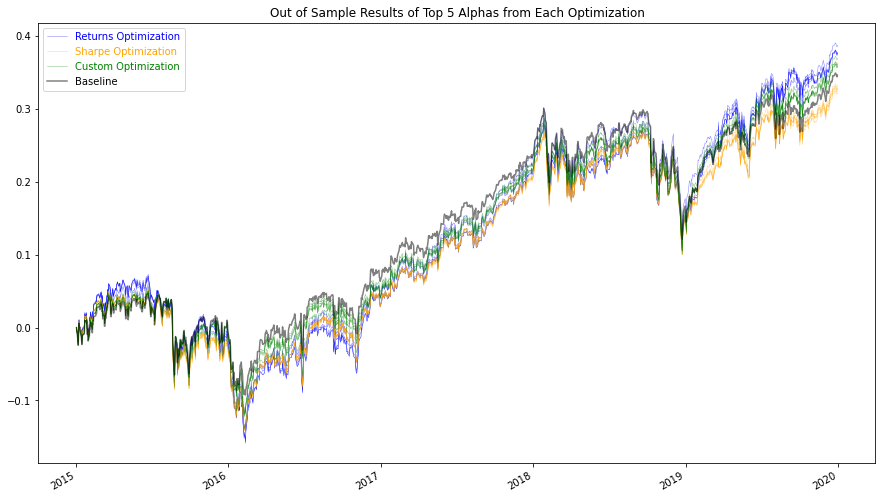

In [33]:
fig, ax = plt.subplots(1)
double_returns.iloc[:, :n].cumsum().plot(lw=.5, color='blue', alpha=.5, ax=ax)
double_returns.iloc[:, n:n+n].cumsum().plot(lw=.5, color='orange', alpha=.5, ax=ax)
double_returns.iloc[:, n+n:-1].cumsum().plot(lw=.5, color='green', alpha=.5, ax=ax)
double_returns.iloc[:, -1].cumsum().plot(color='black', alpha=.5, ax=ax, label='Baseline')
ax.legend(
    loc='upper left', handles=ax.get_lines()[::n],
    labelcolor=['blue', 'orange', 'green', 'black'],
    labels=['Returns Optimization', 'Sharpe Optimization', 'Custom Optimization', 'Baseline']
)
plt.title(f'Out of Sample Results of Top {n} Alphas from Each Optimization')
fig.show()

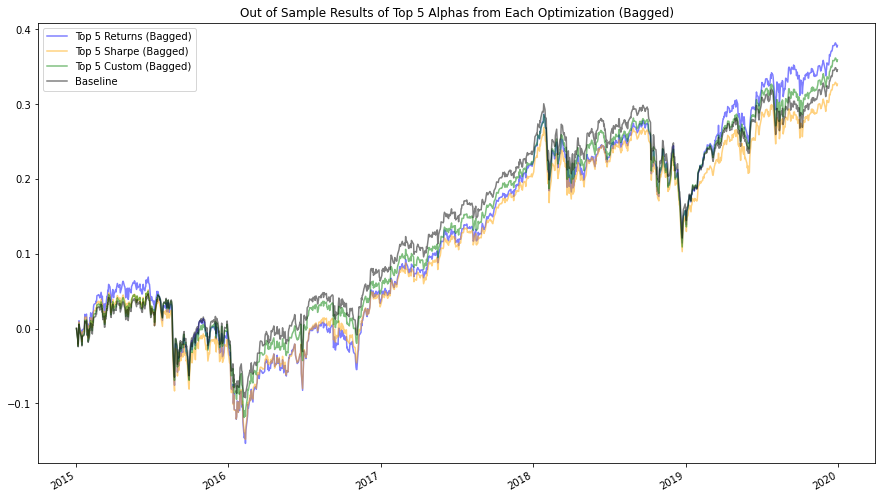

In [34]:
fig, ax = plt.subplots(1)
double_returns.iloc[:, :n].cumsum().mean(axis=1).plot(color='blue', alpha=.5, ax=ax, label=f'Top {n} Returns (Bagged)')
double_returns.iloc[:, n:n+n].cumsum().mean(axis=1).plot(color='orange', alpha=.5, ax=ax, label=f'Top {n} Sharpe (Bagged)')
double_returns.iloc[:, n+n:].cumsum().mean(axis=1).plot(color='green', alpha=.5, ax=ax, label=f'Top {n} Custom (Bagged)')
double_returns.iloc[:, -1].cumsum().plot(color='black', alpha=.5, ax=ax, label='Baseline')
ax.legend(loc='upper left')
plt.title(f'Out of Sample Results of Top {n} Alphas from Each Optimization (Bagged)')
fig.show()

#### Results & Analysis

The yearly and overall performance for each optimized alpha (bagged) is shown below where we can finally confirm that the custom metric did succeed in finding optimal hyperparameters that also reduced the overall turnover of the strategy. The custom metric also balanced return and sharpe ratio which it still managed to get close to the top in each statistic, relative to the other optimizations. The final table below the results shows the correlations between the returns for the backtested alphas, including the baseline. They are separated into groups of 5 which is the color separations shows, with the intra-optimization correlations being very close, and the inter-optimization correlations being slightly more divided. This pattern is only interrupted by the last alpha of the custom which we noted earlier was an outlier for the custom optimization. The differences are not very significant because the correlations are all strong with the lowest being around `.98`, therefore the hyperparameters must have little effect on the overall strategy, at least among the set we have tested here.

In [35]:
from sif.siftools.metrics import generate_performance_table
multiple_perf_tables = alpha_search.apply_metric_func(generate_performance_table, ('daily_returns', 'holdings'))

double_perf = multiple_perf_tables(double_returns, double_holdings)
returns_performance = pd.concat(double_perf[:n])
returns_bagged_performance = returns_performance.groupby(returns_performance.index).mean()
sharpe_performance = pd.concat(double_perf[n:n+n])
sharpe_bagged_performance = sharpe_performance.groupby(sharpe_performance.index).mean()
custom_performance = pd.concat(double_perf[n+n:])
custom_bagged_performance = custom_performance.groupby(custom_performance.index).mean()

In [36]:
returns_bagged_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.019399 -0.133338 -0.185960  0.137065  0.093244  254.524603   
2016     0.052903  0.387146  0.488714  0.116976  0.085743  277.854762   
2017     0.183398  2.579779  3.595400  0.024487  0.048866  319.200000   
2018    -0.059022 -0.393736 -0.477592  0.167045  0.078253  270.887649   
2019     0.220599  2.059837  2.701213  0.057192  0.080260  273.124603   
Overall  0.378478  0.601810  0.747921  0.207842  0.077932  279.093005   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [37]:
sharpe_bagged_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.029642 -0.204815 -0.286697  0.128759  0.029758  261.960317   
2016     0.058558  0.448428  0.564699  0.103565  0.035778  296.744444   
2017     0.173621  2.456620  3.468667  0.027501  0.017899  336.038247   
2018    -0.053106 -0.361643 -0.444594  0.160707  0.028718  293.534661   
2019     0.177379  1.735505  2.198878  0.057394  0.030408  288.870635   
Overall  0.326809  0.533063  0.663814  0.189298  0.029318  295.398887   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [38]:
custom_bagged_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.009462 -0.064967 -0.090213  0.116854  0.020435  283.583995   
2016     0.055684  0.464368  0.585027  0.094957  0.023401  292.339947   
2017     0.172767  2.451231  3.381654  0.026809  0.010600  357.018592   
2018    -0.061108 -0.409161 -0.504809  0.170960  0.018952  306.471448   
2019     0.201218  1.933517  2.467943  0.055311  0.018200  306.150794   
Overall  0.359100  0.591332  0.733630  0.174373  0.019047  309.076974   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [39]:
double_returns.corr().style.background_gradient(
    cmap=plt.cm.viridis, axis=None
).set_properties(**{'font-size': '6pt'})

## Triple Moving Average Optimization

In this final section we will repeat a similar analysis on the `TripleMoving` strategy which implements a double crossover strategy with three moving averages. The optimization will tune the hyperparameters of the strategy which are the three window sizes of the moving averages. Because of the constraints between the hyperparameters, there are a limited number of hyperparameter combinations we can test, given by: $\sum_{t_1=7}^{252}\sum_{t_2=6}^{t_1} (t_2 - 5) = 2542123$. The results below are from 4096 trials, or `0.16%` of the possible combinations. This will not give us a full representation of the search space, but the randomization will provide a decent distribution for further analysis. Unfortunately because of the parameter constraints, `ray.tune` will only allow us to use the random approach, and we can not take advantage of the other search algorithms.

After completing 4096 trials on this search space for the `TripleMoving` strategy, the best set of hyperparameters we find are `t1=122, t2=100, t3=53`, corresponding to moving averages of 122, 100, and 53 trading days respectively. This trial achieved a `138%` cumulative return within the in-sample period, which is actually the same as the returns optimization for the `DoubleMoving` strategy. More interestingly is the relative weight analysis of the hyperparameters. For this optimization we find the weight attributed to `t1` and `t2` are nearly `40%`, with `t3` being just `20%`. This gives us an idea for which hyperparameters have greater effects on the strategy's performance. In the `DoubleMoving` strategy the smallest window size was estimated to explain approximately `20%` of the score, which is similar in this analysis as the other `80%` is split almost evenly between the larger 2 window sizes.

In [40]:
space = {
    't1': tune.sample_from(lambda _: np.random.randint(7, 253)), 
    't2': tune.sample_from(lambda spec: np.random.randint(6, spec.config.t1)),
    't3': tune.sample_from(lambda spec: np.random.randint(5, spec.config.t2))
}
# triple_result = alpha_search.tune_search(TripleMoving, backtester, 'return', space, 4096, algo='random', seed=42, verbose=1, resources={'cpu': 1}, store_results=False)

In [41]:
# with open('triple_search_result.pkl', 'wb') as f:
#     pickle.dump(triple_result, f)

with open('triple_search_result.pkl', 'rb') as f:
    triple_result = pickle.load(f)
print(triple_result)

This search result contains 4096 trials across 3 parameters
The best alpha achieved a score of 1.388897453467269 on trial 2411 with parameters: {'t1': 122, 't2': 100, 't3': 53}
The following parameter importances are calculated using a relative weights analysis:
{'param_t1': 0.3985701360432643, 'param_t2': 0.4360039406320486, 'param_t3': 0.165425923324687}


### Results & Analysis

Here we plot the distribution of all hyperparameters against the returns achieved for that trial, and also compute features to show how the differences between the window sizes affects the strategy's performance in the bottom two graphs (`MA Difference 1 & 2`). These distributions are very comparable to the ones we plotted for the `DoubleMoving` strategy where there does not seem to be a significant relationship that we can clearly see. Each moving average size is able to achieve average performance for most of the range, with only the lower end particularly suffering consistently poor performance. Further, each window size has a distinct optimal point in its consistent range, which may be an area of optimization that we could observe more closely by looking at multiple dimensions at once. The distribution for the `MA Difference 1` appears to be almost entirely random, with an even distribution throughout, going against the logarithmic shape we see in the other distributions.

In [42]:
df = triple_result.results
df.eval('diff1 = param_t1 - param_t2', inplace=True)
df.eval('diff2 = param_t2 - param_t3', inplace=True)

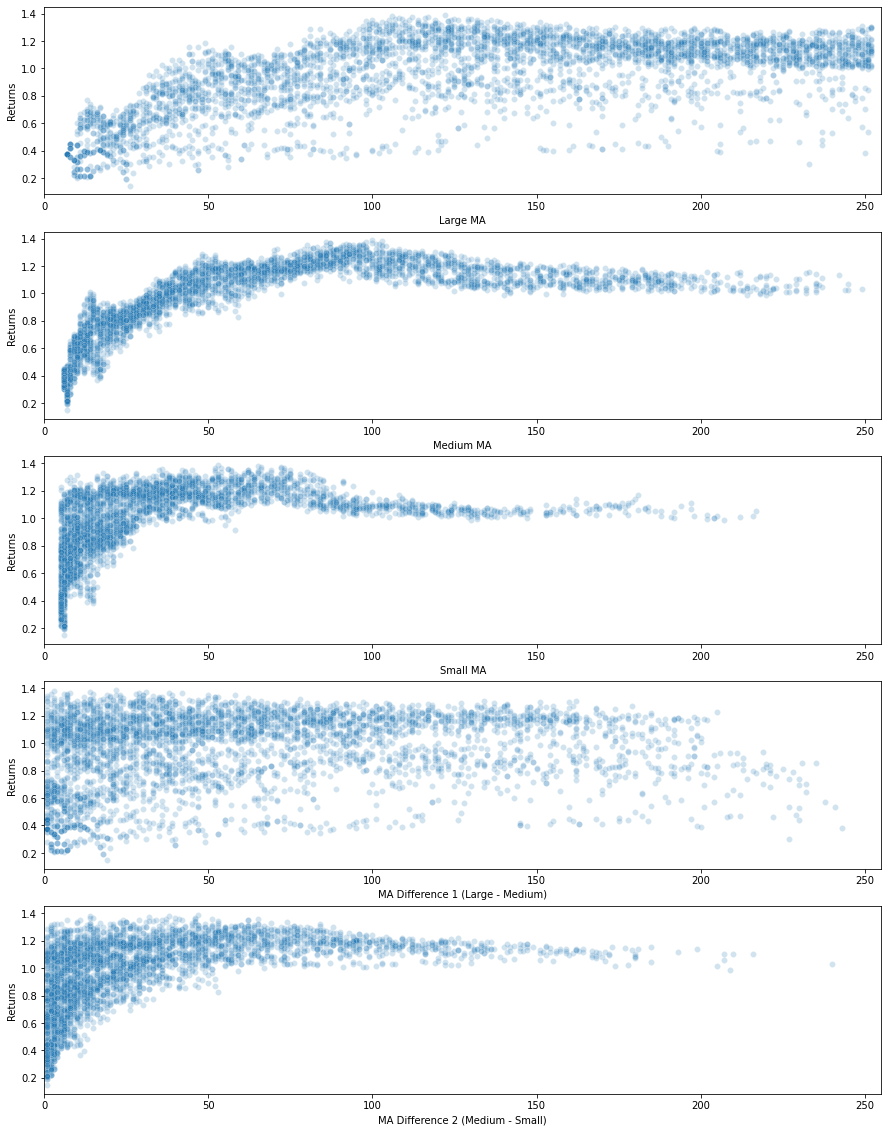

In [43]:
_, axes = fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharey=True, figsize=(15, 20))
sns.scatterplot(x=df['param_t1'], y=df['score'], ax=ax1, alpha=.2)
sns.scatterplot(x=df['param_t2'], y=df['score'], ax=ax2, alpha=.2)
sns.scatterplot(x=df['param_t3'], y=df['score'], ax=ax3, alpha=.2)
sns.scatterplot(x=df['diff1'], y=df['score'], ax=ax4, alpha=.2)
sns.scatterplot(x=df['diff2'], y=df['score'], ax=ax5, alpha=.2)
ax1.set_xlabel('Large MA')
ax2.set_xlabel('Medium MA')
ax3.set_xlabel('Small MA')
ax4.set_xlabel('MA Difference 1 (Large - Medium)')
ax5.set_xlabel('MA Difference 2 (Medium - Small)')
for ax in axes:
    ax.set_ylabel('Returns')
    ax.set_xlim(0, 255)
fig.show()

### Out-of-Sample Analysis

Moving ahead to the out-of-sample analysis, I thought it still was not entirely clear if the hyperparameter tuning had a tangible effect on the future performance of the strategy. To test this hypothesis I need to know if the bad hyperparameters found and the good hyperparameters found are actually good: Is there a statistically significant relationship between the hyperparameters chosen, and the resulting strategy performance? The out-of-sample backtest below should help us answer this. It uses the alphas from the top 10 and bottom 10 hyperparameters from the in-sample period, and simulates them in the out-of-sample-period. The cumulative return graphs are shown below where the top 10 are in blue, bottom top 10 in orange with descending saturation to distinguish ranks 1 through 10 of each group. The baseline `TripleMoving` strategy has also been added to compare these against the original hyperparameters used.

After one year into the out-of-sample backtest the top and bottom groups' cumulative returns diverge almost entirely, with very little overlap. This is a promising result as it provides evidence that the pattern found in the in-sample period is likely to continue into the future. The top and bottom groups continue to diverge over the five year period, finishing almost `20%` apart in cumulative returns. The baseline tracked the top group for a considerable amount of time before eventually falling to the middle of the pack, between the top and and bottom groups. A histogram of these returns is shown below which provides more detailed characteristics of the behavior of the strategies. Though the bottom alphas manage an average greater than the top group, the alphas in the top group have a stronger positive skew which results in better performance overall. The final graph in this set averages the alphas in each group to form single bagged alphas as we did previously. From this picture we are able to more clearly see the trends of the contrasting groups. The bottom group distinctly lags the top hyperparameters, however, the actual performance gained from the optimization is unclear as the baseline is able to track the top group, even surpassing it in some periods, and only falling in the last 18 months of the backtest period. Therefore it is difficult to confidently say the optimization's performance gains are statistically significant over the baseline alpha that is backed by economic intuition. We can look more closely at this with the yearly performance breakdown below.

In [44]:
n = 10
triple_returns, triple_holdings = oos_backtester.backtest(
    triple_result.top_n_alphas(n) + triple_result.bot_n_alphas(n) + [TripleMoving(200, 21, 9)]
)

Done!: 100%|██████████| 21/21 [00:29<00:00,  1.38s/it]


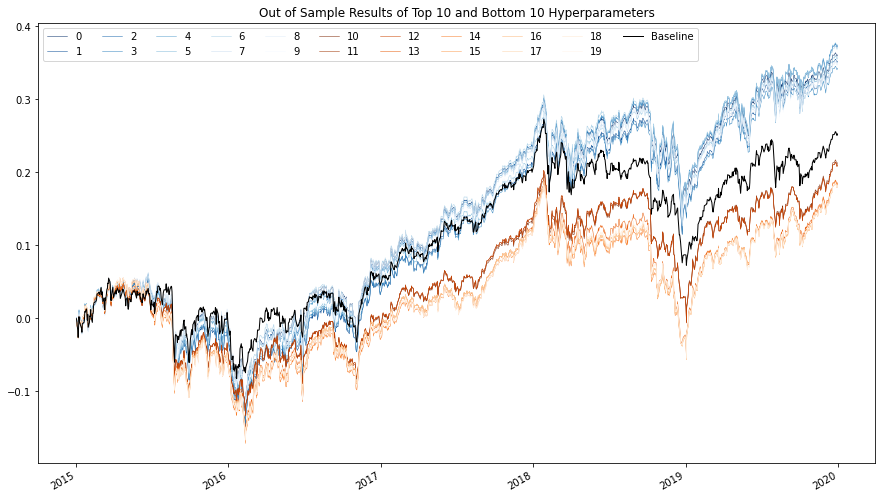

In [45]:
fig, ax = plt.subplots(1)
triple_returns.iloc[:, :n].cumsum().plot(lw=.5, cmap=plt.cm.Blues_r, ax=ax)
triple_returns.iloc[:, n:-1].cumsum().plot(lw=.5, cmap=plt.cm.Oranges_r, ax=ax)
triple_returns.iloc[:, -1].cumsum().plot(lw=1, color='black', ax=ax, label='Baseline')
ax.legend(loc='upper left', ncol=n+1)
plt.title(f'Out of Sample Results of Top {n} and Bottom {n} Hyperparameters')
fig.show()

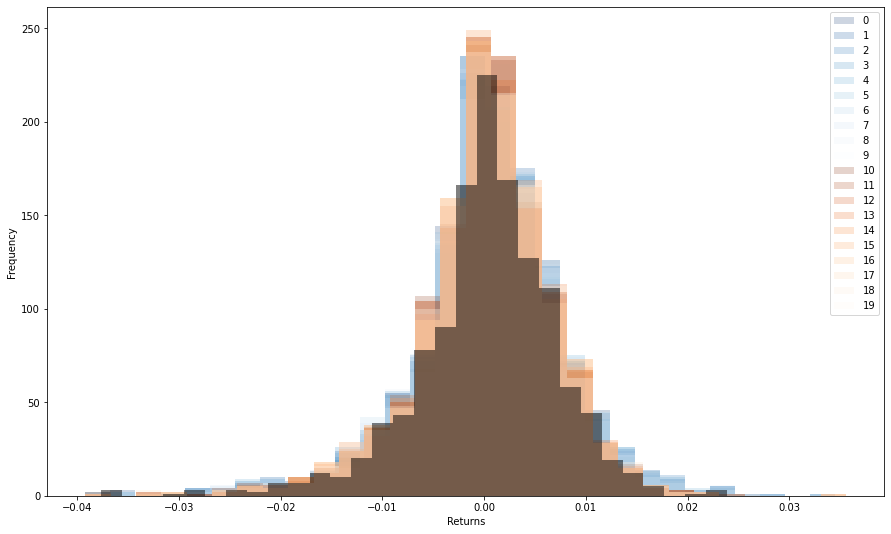

In [46]:
fig, ax = plt.subplots(1)
triple_returns.iloc[:, :n].plot.hist(lw=1, cmap=plt.cm.Blues_r, alpha=.2, ax=ax, label='Baseline', bins=30)
triple_returns.iloc[:, n:-1].plot.hist(lw=1, cmap=plt.cm.Oranges_r, alpha=.2, ax=ax, label='Baseline', bins=30)
triple_returns.iloc[:, -1].plot.hist(lw=1, color='black', ax=ax, alpha=.5, label='Baseline', bins=30)
ax.set_xlabel('Returns')
fig.show()

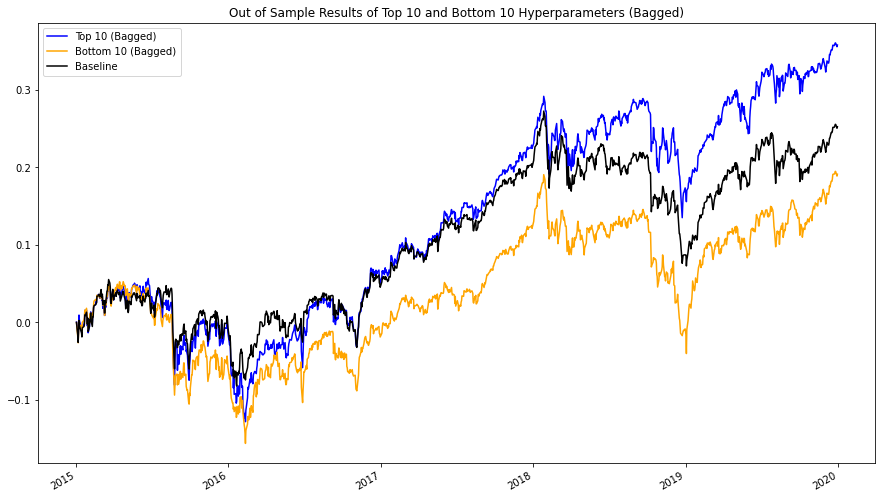

In [47]:
fig, ax = plt.subplots(1)
triple_returns.iloc[:, :n].cumsum().mean(axis=1).plot(color='blue', ax=ax, label='Top 10 (Bagged)')
triple_returns.iloc[:, n:-1].cumsum().mean(axis=1).plot(color='orange', ax=ax, label='Bottom 10 (Bagged)')
triple_returns.iloc[:, -1].cumsum().plot(color='black', ax=ax, label='Baseline')
ax.legend(loc='upper left')
plt.title(f'Out of Sample Results of Top {n} and Bottom {n} Hyperparameters (Bagged)')
fig.show()

#### Results & Analysis

From the performance breakdown we see that the top bagged alphas perform better than the bottom bagged alphas in all years except for 2019 with respect to returns, sharpe ratio, sortino ratio, turnover, and max drawdown (except 2016). Further, the top alphas also outperform the baseline in every year except 2015 in all categories, not including sortino ratio in 2016 and max drawdown in 2016 & 2017. This provides supplementary evidence the the signals created by these groups of hyperparameters are consistent in their behavior even over smaller time frames. We also can view the strength of the relationship between hyperparameters through the correlation plot below the results. The inter-group correlations are very strong, `>.85`, but the intra-group correlations are even stronger, `>.95`, showing that while the signals do remain similar, the hyperparameters are able to slightly adjust the nature of the systematic rules. The outer edge of the correlation chart shows the correlations between the tuned parameters and the baseline. This shows that the baseline signal is more closely related to the alphas for the top hyperparameter group, than that of the bottom hyperparameter group.

In [48]:
triple_perf = multiple_perf_tables(triple_returns, triple_holdings)
top_performance = pd.concat(triple_perf[:n])
top_bagged_performance = top_performance.groupby(top_performance.index).mean()
bot_performance = pd.concat(triple_perf[n:-1])
bot_bagged_performance = bot_performance.groupby(bot_performance.index).mean()
baseline_performance = triple_perf[-1]

In [49]:
top_bagged_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.013585 -0.094165 -0.131722  0.130909  0.035736  224.946429   
2016     0.064276  0.497720  0.618911  0.100713  0.044163  237.955556   
2017     0.173852  2.416814  3.410550  0.029153  0.020836  298.850598   
2018    -0.051002 -0.355870 -0.436630  0.152872  0.035846  250.773307   
2019     0.184432  1.823470  2.336992  0.055694  0.034120  246.075794   
Overall  0.357974  0.590015  0.734166  0.176962  0.037745  251.683625   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [50]:
bot_bagged_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.058151 -0.445453 -0.604501  0.150369  0.630160  166.118254   
2016     0.039193  0.327687  0.436383  0.086430  0.523219  197.550000   
2017     0.140253  2.179556  2.865606  0.036157  0.442644  210.154980   
2018    -0.129811 -1.095153 -1.311588  0.193115  0.515387  178.266534   
2019     0.199746  1.949447  2.570145  0.051245  0.467316  217.342460   
Overall  0.191231  0.348753  0.437302  0.211816  0.522079  193.885930   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [51]:
baseline_performance

return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2015    -0.006977 -0.052567 -0.069366  0.113539  0.189560  155.519841   
2016     0.052252  0.481039  0.664283  0.069182  0.157814  177.873016   
2017     0.154815  2.341869  3.119989  0.025345  0.114489  231.729084   
2018    -0.112953 -0.877128 -0.995025  0.184992  0.176264  177.346614   
2019     0.165413  1.722217  2.177099  0.063856  0.126983  210.623016   
Overall  0.252550  0.461865  0.561441  0.187857  0.157753  190.596184   

         short count  
year                  
2015             0.0  
2016             0.0  
2017             0.0  
2018             0.0  
2019             0.0  
Overall          0.0

In [52]:
triple_returns.corr().style.background_gradient(
    cmap=plt.cm.viridis, axis=None
).set_properties(**{'font-size': '6pt'})

#### Results & Analysis

I wanted to investigate these relationships more exactly; specifically, given the different time series of returns from the out-of-sample backtests, test the probability that these returns were drawn from the same random distribution. In researching this I came across the [Kolmogorov-Smirnov 2 sample test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test) (KS-2test) which tests whether two underlying one-dimensional probability distributions differ from one another. Using `scipy.stats.ks_2samp` I was able to compute the ks statistic and associated p-value for each pair of alpha strategy's returns. The statistic values are shown in the first chart with the p-values in the second. Higher ks-statistics mean that the underlying probability distributions are suspected to be further apart. Despite this, in the bottom chart we see that none of the p-values are significant, with the lowest being `>0.5` which is still way beyond the `5%` significance level. This was expected though because the signals do not vary greatly, so viewing it as a random distribution, it would have to exhibit abnormal behavior to confidently say they are drawn from different probability distributions.

Nevertheless, these charts provide a nice visualization in understanding the relatedness between the strategy's of the various hyperparameters. Despite not being statistically significant, these statistics do support what we concluded from the prior correlations which was that the top and bottom groups do behave extremely similar within the groups, but do have stark differences when looking at alphas from across groups.

In [53]:
from scipy import stats
ks_stats = pd.DataFrame(index=range(triple_returns.shape[1]), columns=range(triple_returns.shape[1]), dtype=float)
ks_pvalues = pd.DataFrame(index=range(triple_returns.shape[1]), columns=range(triple_returns.shape[1]), dtype=float)
for i in range(triple_returns.shape[1]):
    for j in range(triple_returns.shape[1]):
        stat, pval = stats.ks_2samp(triple_returns.iloc[:, i], triple_returns.iloc[:, j])
        ks_stats.iloc[i, j] = stat
        ks_pvalues.iloc[i, j] = pval

In [54]:
ks_stats.style.background_gradient(
    cmap=plt.cm.viridis, axis=None
).set_properties(**{'font-size': '6pt'})

In [55]:
ks_pvalues.style.background_gradient(
    cmap=plt.cm.viridis, axis=None
).set_properties(**{'font-size': '6pt'})

### More parameter visualizations

In this last section I created a tool to dynamically build sankey graphs of the value counts in each column of a dataframe. These are difficult to interpret, and false inferences can be made easily so I will not provide much commentary on these. The graphs plotted show the binned hyperparameters as they relate to to each other, and the final score of the trial (also binned). As such, the 1-to-1 graphs in the first set do show some interesting traits of the hyperparameters with respect to the score output. After adding multiple layers by plotting `>1` hyperparameters at a time, the conclusions become much more difficult to intrepret, but may provide some value if analyzed carefully. I have kept them in this showcase for viewing pleasure, and they may become part of our future visualization infrastructure. Another step for this visualization could be to normalize the in-bin counts which would make the relationships shown much more valuable.

In [56]:
import plotly.graph_objects as go
from itertools import cycle

def parallel_coordinates(df, format_str="{}={}", colors=['red', 'blue', 'orange', 'green', 'yellow', 'purple']):
    counts = df.apply(lambda x: x.value_counts().to_dict())
    col_vals = [(col, val) for col in counts.index for val in counts[col]]
    labels = [format_str.format(col, val) for col, val in col_vals]
    
    source, target, value, = [], [], []
    for curr_col, next_col in zip(df.columns, df.columns[1:]):
        temp = df[[curr_col, next_col]].groupby(curr_col)[next_col].value_counts()
        for (curr_val, next_val), num in temp.iteritems():
            source.append(col_vals.index((curr_col, curr_val)))
            target.append(col_vals.index((next_col, next_val)))
            value.append(num)
    
    colors_map = {col: color for col, color in zip(df.columns, cycle(colors))}
    colors = [colors_map[col] for col, _ in col_vals]
    fig = go.Figure(
        data=[go.Sankey(
            node = {'label': labels, 'color': colors},
            link = {'source': source, 'target': target, 'value': value}
        )]
    )
    return fig


def paired_parallel_coordinates(
    df, target_col='score', format_str="{}={}", colors=['red', 'blue', 'orange', 'green', 'yellow', 'purple']
):
    if target_col not in df.columns:
        raise AttributeError
    figs = [
        parallel_coordinates(df[[col, target_col]], format_str, colors) 
        for i, col in enumerate(df.columns[df.columns != target_col], 1)
    ]
    return figs

In [57]:
foo = triple_result.results[['param_t1', 'param_t2', 'param_t3', 'diff1', 'diff2', 'score']].apply(lambda x: pd.cut(x, 5))
foo.columns = ['t1', 't2', 't3', 'diff1', 'diff2', 'score']
figs = paired_parallel_coordinates(foo)
for fig in figs:
    fig.show()
fig.show()

In [58]:
foo = triple_result.results[['param_t1', 'param_t2', 'param_t3', 'score']].apply(lambda x: pd.cut(x, 5))
foo.columns = ['t1', 't2', 't3', 'score']
fig = parallel_coordinates(foo)
fig.show()

In [59]:
foo = triple_result.results[['param_t1', 'param_t2', 'param_t3', 'diff1', 'diff2', 'score']].apply(lambda x: pd.cut(x, 5))
foo.columns = ['t1', 't2', 't3', 'diff1', 'diff2', 'score']
fig = parallel_coordinates(foo)
fig.show()

## Future Work

* Use hyperparameter tuning on different types of strategies other than moving averages
  * Tune hyperparameters that don't have constraints so the optimization can leverage more efficient search algorithms
* Produce more interprative visualizations for tuning `>2` hyperparameters.
  * Test the effect of the number of trials on the final optimization